## Rodent Inspections/Baiting

All rodent inspection data are available at <a href="https://data.cityofnewyork.us/Health/Rodent-Inspection/p937-wjvj">NYC Open Data</a>. We will be working with data from Jan 2013 to July 2017:

In [3]:
# <!-- collapse=None -->
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sodapy import Socrata

sns.set(style="dark", rc={"figure.figsize": (16,10)}, font_scale=1.5)

df = pd.read_csv("~/Downloads/rats.csv", usecols=["INSPECTION_TYPE", "JOB_ID",
                                      "JOB_PROGRESS",
                                      "ZIP_CODE",
                                      "RESULT", "INSPECTION_DATE",
                                      "LONGITUDE", "LATITUDE"])
# Remove jobs with null items
null_inspection_date = df.INSPECTION_DATE.isnull()
null_zip_code = df.ZIP_CODE.isnull()
null_result = df.RESULT.isnull()
null_cols = null_inspection_date | null_zip_code | null_result

has_null_job_ids = df.loc[null_cols, "JOB_ID"].unique()

df = df[~df.JOB_ID.isin(has_null_job_ids)]
df = (df.assign(ZIP_CODE = df.ZIP_CODE.astype(int),
               INSPECTION_DATE = pd.to_datetime(
                   df.INSPECTION_DATE, format="%m/%d/%Y %X %p"))
        .sort_values(["JOB_ID", "JOB_PROGRESS"]))

# 2015-2017
df = df[(df.INSPECTION_DATE >= pd.Timestamp('2013-01-01')) & 
         (df.INSPECTION_DATE <= pd.Timestamp('2017-07-29'))]
df.head()

,INSPECTION_TYPE,JOB_ID,JOB_PROGRESS,ZIP_CODE,LATITUDE,LONGITUDE,INSPECTION_DATE,RESULT
929989,INITIAL,PO1000000,1,10457,40.850778,-73.887226,2015-07-03 01:18:47,Passed Inspection
929990,INITIAL,PO1000003,1,11419,40.691459,-73.820706,2015-07-08 02:55:49,Passed Inspection
929991,INITIAL,PO1000004,1,11354,40.764792,-73.828963,2015-07-10 04:15:13,Active Rat Signs
288082,COMPLIANCE,PO1000004,2,11354,40.764792,-73.828963,2015-10-01 11:00:36,Passed Inspection
929992,INITIAL,PO1000018,1,11368,40.747279,-73.862460,2015-07-21 10:30:12,Problem Conditions


Each site is given a `JOB_ID`, where `JOB_PROGRESS` increases with every revisit to the location. There are a total of four inspection types: 

- Initial Inspection (INITIAL) - Inspection responding to 311 call
- Compliance Inspection (COMPLIANCE) - After failing initial inspection, a follow up will be conducted. 
- Baiting - Application of rodenticide or monitoring
- Clean Up - Removal of garbage and clutter 

Taking a look at the number of inspections done since 2015, there is a noticeable uptick in inspections during the first half of 2017: 

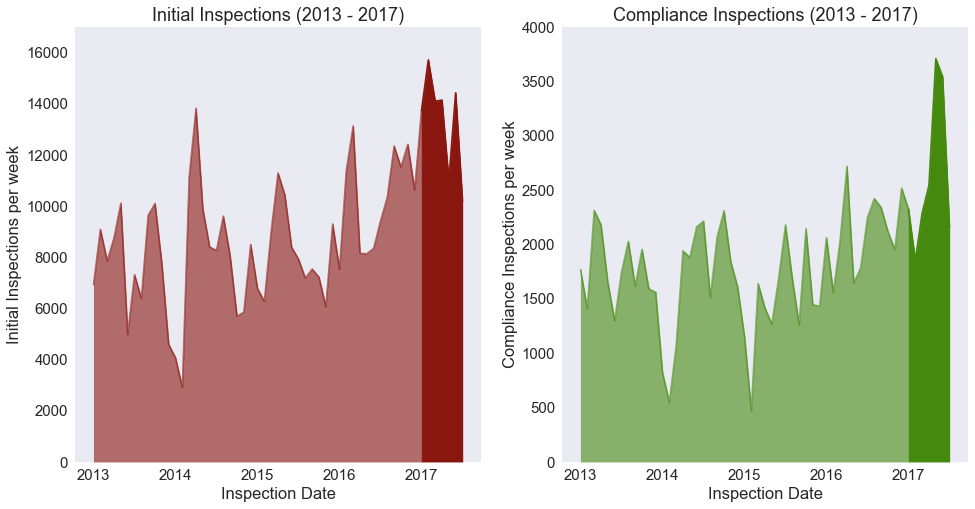

In [4]:
# <!-- collapse=None -->
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
colors = sns.hls_palette(4, l=.3, s=.8)

initial = (df.query("INSPECTION_TYPE == 'INITIAL'")
            .resample('M', on="INSPECTION_DATE")["RESULT"].count())
compliance = (df.query("INSPECTION_TYPE == 'COMPLIANCE'")
            .resample('M', on="INSPECTION_DATE")["RESULT"].count())

pre_2017_bool = initial.index <= pd.Timestamp("2017-02-01")
post_2017_bool = initial.index >= pd.Timestamp("2017-01-01")

init_pre_2017 = initial[pre_2017_bool]
init_pre_2017.plot(kind="area", color=colors[0], ax=ax1, alpha=0.6)

init_post_2017 = initial[post_2017_bool]
init_post_2017.plot(kind="area", color=colors[0], ax=ax1, alpha=1)

_ = ax1.set_title("Initial Inspections (2013 - 2017)")
_ = ax1.set_xlabel("Inspection Date")
_ = ax1.set_ylabel("Initial Inspections per week")
_ = ax1.set_ylim([0, 17000])

comp_pre_2017 = compliance[pre_2017_bool]
comp_pre_2017.plot(kind="area", color=colors[1], ax=ax2, alpha=0.6)

comp_post_2017 = compliance[post_2017_bool]
comp_post_2017.plot(kind="area", color=colors[1], ax=ax2, alpha=1)

_ = ax2.set_title("Compliance Inspections (2013 - 2017)")
_ = ax2.set_xlabel("Inspection Date")
_ = ax2.set_ylabel("Compliance Inspections per week")
_ = ax2.set_ylim([0, 4000])


As of this blog post, we only have data for the first 7 months in 2017, lets compare the change in inspection count for the first 7 months year over year:

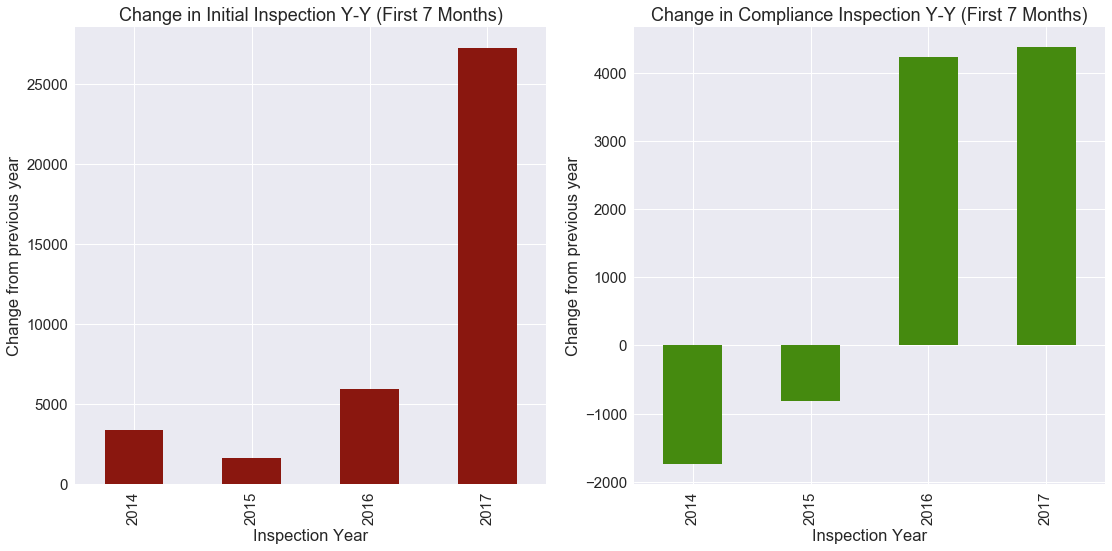

In [5]:
# <!-- collapse=None -->
initial_diff = (initial[initial.index.month.isin([1,2,3,4,5,6,7])]
               .resample("A").sum().diff().dropna())
initial_diff.index = initial_diff.index.year
initial_diff.index.name = "Inspection Year"

compliance_diff = (compliance[compliance.index.month.isin([1,2,3,4,5,6,7])]
                  .resample("A").sum().diff().dropna())
compliance_diff.index = compliance_diff.index.year
compliance_diff.index.name = "Inspection Year"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
initial_diff.plot(kind="bar", ax=ax1, color=colors[0])
_ = ax1.set_ylabel("Change from previous year")
_ = ax1.set_title("Change in Initial Inspection Y-Y (First 7 Months)")
_ = ax1.grid()

compliance_diff.plot(kind="bar", ax=ax2, color=colors[1])
_ = ax2.set_title("Change in Compliance Inspection Y-Y (First 7 Months)")
_ = ax2.set_ylabel("Change from previous year")
_ = ax2.grid()
fig.tight_layout()

In the first 7 months of 2017, there was 27,000 more more initial inspections compared to 2016. Over the same period, there has been 4,000 more compliance inspections. Similarly, there is a increase activity in baiting during 2017. With clean ups per week in the teens and baiting per week in the thousands, NYC overwhelming prefers baiting than physical clean ups:

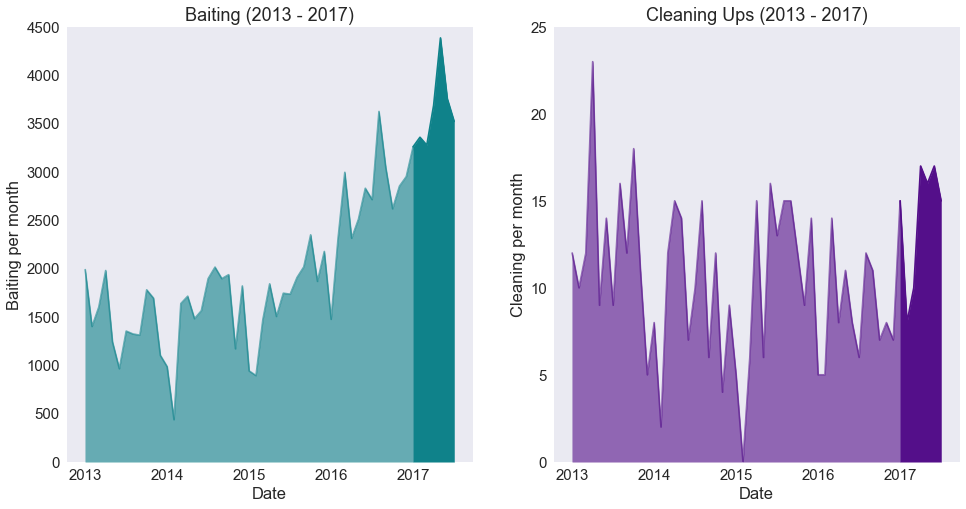

In [6]:
# <!-- collapse=None -->
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

bait = (df.query("INSPECTION_TYPE == 'BAIT'")
            .resample('M', on="INSPECTION_DATE")["RESULT"].count())
clean_up = (df.query("INSPECTION_TYPE == 'CLEAN_UPS'")
            .resample('M', on="INSPECTION_DATE")["RESULT"].count())

bait_pre_2017 = bait[pre_2017_bool]
bait_pre_2017.plot(kind="area", color=colors[2], ax=ax1, alpha=0.6)

bait_post_2017 = bait[post_2017_bool]
bait_post_2017.plot(kind="area", color=colors[2], ax=ax1, alpha=1)

_ = ax1.set_title("Baiting (2013 - 2017)")
_ = ax1.set_xlabel("Date")
_ = ax1.set_ylabel("Baiting per month")
_ = ax1.set_ylim([0, 4500])

clean_up_pre_2017 = clean_up[pre_2017_bool]
clean_up_pre_2017.plot(kind="area", color=colors[3], ax=ax2, alpha=0.6)

clean_up_post_2017 = clean_up[post_2017_bool]
clean_up_post_2017.plot(kind="area", color=colors[3], ax=ax2, alpha=1)

_ = ax2.set_title("Cleaning Ups (2013 - 2017)")
_ = ax2.set_xlabel("Date")
_ = ax2.set_ylabel("Cleaning per month")
_ = ax2.set_ylim([0, 25])

In the past two years, there has been an increase in 7,000 baiting events relative to the previous year:

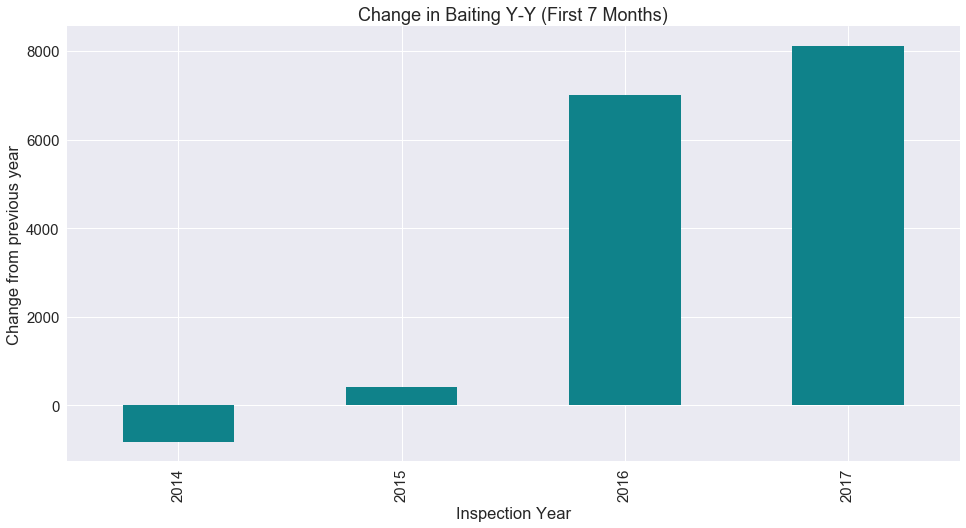

In [7]:
# <!-- collapse=None -->
bait_diff = (bait[bait.index.month.isin([1,2,3,4,5,6,7])]
               .resample("A").sum().diff().dropna())
bait_diff.index = bait_diff.index.year
bait_diff.index.name = "Inspection Year"

fig, ax  = plt.subplots(1, 1, figsize=(16, 8))
bait_diff.plot(kind="bar", ax=ax, color=colors[2])
_ = ax.set_ylabel("Change from previous year")
_ = ax.set_title("Change in Baiting Y-Y (First 7 Months)")
_ = ax.grid()

## Is it working?

From the rodent inspection data, we can see that there is increase activity in trying to get rid of rodents. But how can we tell if it is working? The inspectors do return to a baited location to see if the location is cleared of rats, but that could just mean the rats just moved to another location. One solution is to observe how many rodent related 311 calls are coming in since January 2013. 311 data can be downloaded from <a href="https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/data">NYC Open Data</a>. Here is a sample of the data we will be working with:

In [20]:
# <!-- collapse=None -->
client = Socrata("data.cityofnewyork.us", None, timeout=100)
number_of_ids_resp = client.get("erm2-nwe9", select="count(unique_key)", 
                           where="""created_date > '2013-01-10T12:00:00'
                            and created_date < '2017-08-01T00:00:00'
                            and complaint_type = 'Rodent'""")

num = int(number_of_ids_resp[0]["count_unique_key"])

responses = []
for offset in range(0, num, 50000):
    resp = client.get("erm2-nwe9", 
                      select="incident_zip,created_date,unique_key,borough", 
                   where="""created_date > '2013-01-10T12:00:00'
                            and created_date < '2017-08-01T00:00:00'
                            and complaint_type = 'Rodent'""",
                   limit=50000, offset=offset, content_type="csv")
    responses.extend(resp[1:])
    
df_311 = pd.DataFrame.from_records(responses, 
                          columns=["incident_zip", 
                                   "created_date",
                                   "unique_key",
                                   "borough"])
df_311["created_date"] = pd.to_datetime(df_311["created_date"], format="%m/%d/%Y %X %p")

df_311.head()

,incident_zip,created_date,unique_key,borough
0,10462,2016-05-16 12:00:00,33371211,BRONX
1,10306,2016-05-17 12:00:00,33375487,STATEN ISLAND
2,10463,2016-05-17 12:00:00,33379343,BRONX
3,10462,2016-05-17 12:00:00,33379676,BRONX
4,10463,2016-05-18 12:00:00,33384535,BRONX


Most of the columns were filtered since we are focusing on how the count changes through time. The number of rodent related calls is periodic and is slowly increasing since 2011. Unsurprisingly, there are less rodent complaints during the winter months:

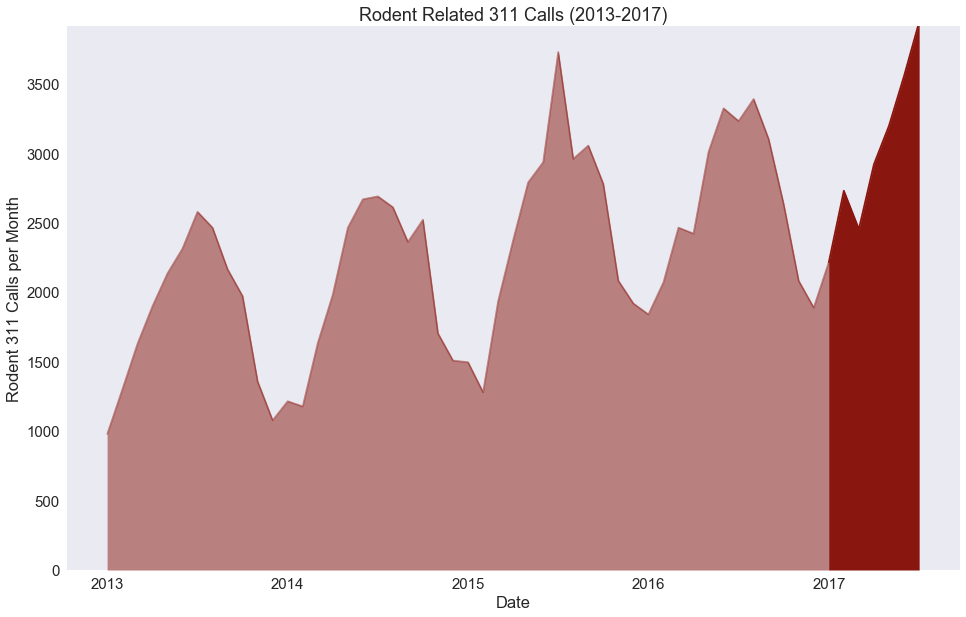

In [21]:
# <!-- collapse=None -->
all_311_rodent_calls = df_311.resample("M", on="created_date")["unique_key"].count()

pre_2017_bool = all_311_rodent_calls.index <= pd.Timestamp("2017-02-01")
post_2017_bool = all_311_rodent_calls.index >= pd.Timestamp("2017-01-01")

fig, ax = plt.subplots()
all_311_rodent_calls[pre_2017_bool].plot(kind="area", color=colors[0], ax=ax, alpha=0.5)
all_311_rodent_calls[post_2017_bool].plot(kind="area", color=colors[0], ax=ax)
_ = ax.set_ylabel("Rodent 311 Calls per Month")
_ = ax.set_xlabel("Date")
_ = ax.set_title("Rodent Related 311 Calls (2013-2017)")

The number of rodent calls have been increasing about 2,300 year over year for the past three years:

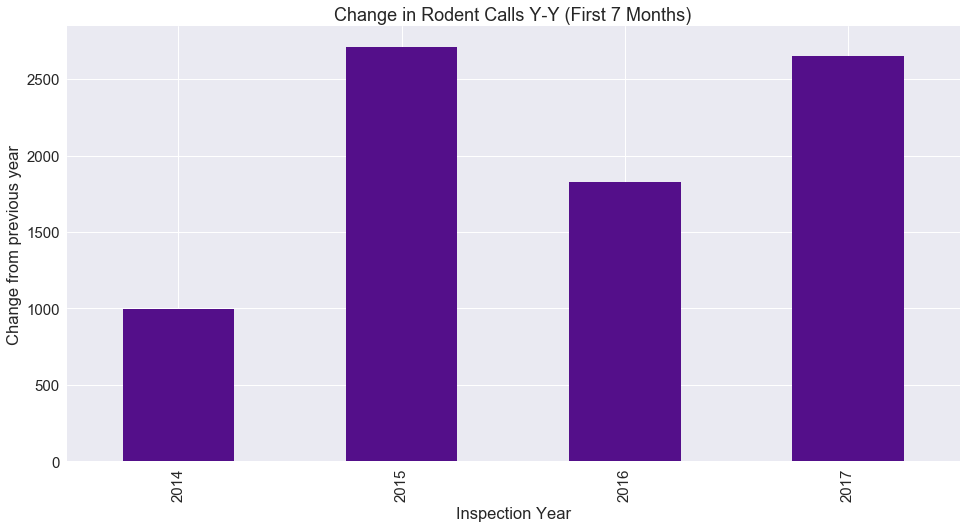

In [22]:
# <!-- collapse=None -->
all_311_diff = (all_311_rodent_calls[all_311_rodent_calls.index.month.isin([1,2,3,4,5,6,7])]
                .resample("A").sum().diff().dropna())
all_311_diff.index = all_311_diff.index.year
all_311_diff.index.name = "Inspection Year"

fig, ax  = plt.subplots(1, 1, figsize=(16, 8))
all_311_diff.plot(kind="bar", ax=ax, color=colors[3])
_ = ax.set_ylabel("Change from previous year")
_ = ax.set_title("Change in Rodent Calls Y-Y (First 7 Months)")
_ = ax.grid()

## Conclusion

Although there is an increase in baiting and inspection activity, there is still an increase of rodent related 311 calls in the same time period. We did manage to decreases the change in rodent calls for 2016, but it came back up to 2,600 in 2017. Mayor Blasio's $34 million plan will fully go into affect at the end of 2017. After the plan comes into affect, we will come back to see if it was able to control the rodent infestation.